A small attempt at fitting SDEs. It seems the diffusion vanishes.

In [159]:
import torch
import torchsde

import matplotlib.pyplot as plt

In [161]:
# As a test case, we can generate data form an Ornstein-Uhlenbeck process
# with state-dependent variance
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class OU_SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, mean=0., peak_variance=1., device=device):
        super().__init__()
        self.mean = torch.tensor(mean, device=device)
        self.peak_variance = torch.tensor(peak_variance, device=device)
        # self.drift = torch.nn.Linear(state_size, 

    # Drift
    def f(self, t, y):
        return self.mean - y

    # Diffusion
    def g(self, t, y):
        return self.peak_variance \
            * torch.exp(-(y - self.mean)**2).unsqueeze(-1)

In [162]:
batch_size = 3
times = 2000
t_span = (0., 4.)
y0 = torch.randn(batch_size,1, device=device)
t_eval = torch.linspace(t_span[0], t_span[1], times, device=device)

In [163]:
ou_sde = OU_SDE(mean=10.)

In [164]:
with torch.no_grad():
    ys = torchsde.sdeint(ou_sde, y0, t_eval)

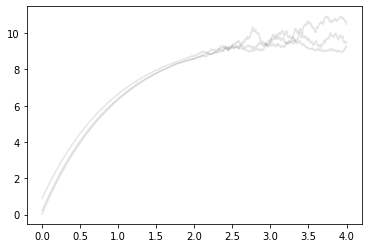

In [165]:
ys_numpy = ys.cpu().numpy()
t_eval_numpy = t_eval.cpu().numpy()
for i in range(ys_numpy.shape[1]):
    plt.plot(
        t_eval_numpy,
        ys_numpy[:,i,0],
        alpha=0.1, color='black')

In [96]:
class Fit_SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, mean=0., peak_variance=1., device=device):
        super().__init__()
        self.mean = torch.nn.Parameter(torch.randn(1, device=device))
        self.peak_variance = torch.nn.Parameter(torch.randn(1, device=device))
        # self.drift = torch.nn.Linear(state_size, 

    # Drift
    def f(self, t, y):
        return self.mean - y

    # Diffusion
    def g(self, t, y):
        return self.peak_variance \
            * torch.exp(-(y - self.mean)**2).unsqueeze(-1)

In [97]:
fit_sde = Fit_SDE()
fit_sde.state_dict()

OrderedDict([('mean', tensor([-0.7221], device='cuda:0')),
             ('peak_variance', tensor([-1.1859], device='cuda:0'))])

In [151]:
optimizer = torch.optim.Adam(fit_sde.parameters(), lr=1e-1)

In [152]:
from IPython.display import clear_output

losses = []
means = [fit_sde.mean.item()]
peak_variances = [fit_sde.peak_variance.item()]

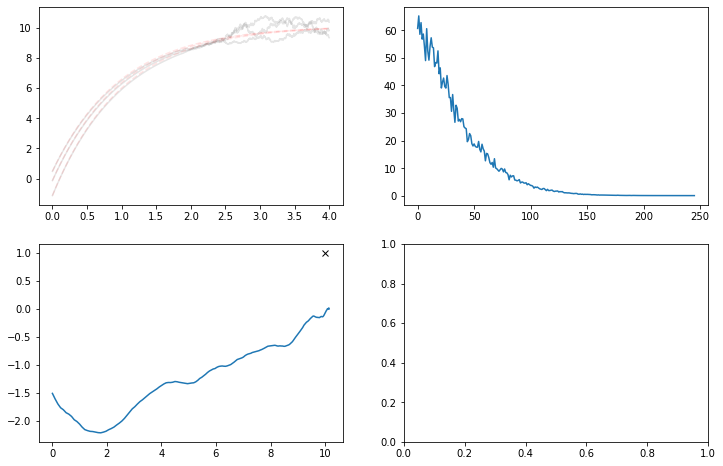

In [154]:
for i in range(1):
    optimizer.zero_grad()
    pred = torchsde.sdeint(fit_sde, y0, t_eval)
    loss = torch.nn.functional.mse_loss(pred, ys)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    means.append(fit_sde.mean.item())
    peak_variances.append(fit_sde.peak_variance.item())
    pred_numpy = pred.detach().cpu().numpy()

    clear_output(wait=True)
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    for i in range(ys_numpy.shape[1]):
        axes[0,0].plot(
            t_eval_numpy,
            ys_numpy[:,i,0],
            alpha=0.1, color='black')
        axes[0,0].plot(
            t_eval_numpy,
            pred_numpy[:,i,0],
            alpha=0.1, color='red',
            ls='--')
    axes[0,1].plot(losses)
    axes[1,0].plot(means, peak_variances)
    axes[1,0].plot(
        ou_sde.mean.cpu().numpy(),
        ou_sde.peak_variance.cpu().numpy(),
        'kx')
    plt.show()

In [158]:
means[-10:], peak_variances[-10:]

([10.129130363464355,
  10.131145477294922,
  10.13309383392334,
  10.134978294372559,
  10.136810302734375,
  10.138580322265625,
  10.140286445617676,
  10.141936302185059,
  10.143527030944824,
  10.145064353942871],
 [0.017569134011864662,
  0.01798170991241932,
  0.018829114735126495,
  0.01866784133017063,
  0.01571526937186718,
  0.013433175161480904,
  0.011159666813910007,
  0.007217146456241608,
  0.004701858386397362,
  0.001732526463456452])

Diffusions appears to disappear. Perhaps we need to use a NeuralCDE as a discriminator, a la [Neural SDEs as Infinite-Dimensional GANs (ArXiv)](https://arxiv.org/abs/2102.03657) or set a prior, [discussed here](https://github.com/google-research/torchsde/issues/113).